# Example: multiple time series, different time values

___
### Getting started

In [12]:
# Import standard packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Xarray is conventionally imported as 'xr'
import xarray as xr
from datetime import timedelta, datetime
from cftime import date2num
from pyproj import Proj
import cartopy as cp
import cartopy.crs as ccrs

## 3. Multiple Time Series with different time values
We create a data set of 2 time series which have
- the same number of elements
- but the time values are different.
- CF conventions, appendix _H.2.2. Incomplete multidimensional array representation of time series_: 
http://cfconventions.org/Data/cf-conventions/cf-conventions-1.10/cf-conventions.html#_incomplete_multidimensional_array_representation_of_time_series

In our example we have:
- 2 real stations from NOAA: https://coastwatch.pfeg.noaa.gov/erddap/files/erdCinpKfmT/
- parameters: sea water temperature


#### load the single data sets

In [13]:
ds_anacapa1 = xr.open_dataset(
    "/data/icdc_main/PROJECTS/nfdi4earth/TA1_3/workshop_netcdf2024/DATA/KFMTemperature_Anacapa_East_Fish_Camp.nc",
    decode_times=False
)
ds_anacapa2 = xr.open_dataset(
    "/data/icdc_main/PROJECTS/nfdi4earth/TA1_3/workshop_netcdf2024/DATA/KFMTemperature_Anacapa_Black_Sea_Bass_Reef.nc",
     decode_times=False
)

In [14]:
ds_anacapa1.info()

xarray.Dataset {
dimensions:
	LON = 1 ;
	LAT = 1 ;
	DEPTH = 1 ;
	TIME = 16733 ;

variables:
	float32 LON(LON) ;
		LON:_CoordinateAxisType = Lon ;
		LON:actual_range = [-119.38333 -119.38333] ;
		LON:axis = X ;
		LON:long_name = Longitude ;
		LON:standard_name = longitude ;
		LON:units = degrees_east ;
	float32 LAT(LAT) ;
		LAT:_CoordinateAxisType = Lat ;
		LAT:actual_range = [34. 34.] ;
		LAT:axis = Y ;
		LAT:long_name = Latitude ;
		LAT:standard_name = latitude ;
		LAT:units = degrees_north ;
	int32 DEPTH(DEPTH) ;
		DEPTH:_CoordinateAxisType = Height ;
		DEPTH:_CoordinateZisPositive = down ;
		DEPTH:actual_range = [11 11] ;
		DEPTH:axis = Z ;
		DEPTH:long_name = Depth ;
		DEPTH:positive = down ;
		DEPTH:standard_name = depth ;
		DEPTH:units = m ;
	float64 TIME(TIME) ;
		TIME:_CoordinateAxisType = Time ;
		TIME:actual_range = [1.12629060e+09 1.18652268e+09] ;
		TIME:axis = T ;
		TIME:long_name = Time ;
		TIME:standard_name = time ;
		TIME:time_origin = 01-JAN-1970 00:00:00 ;
		TIME:uni

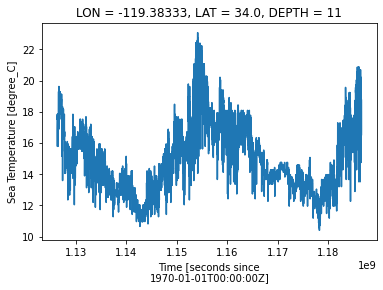

In [15]:
ds_anacapa1["Temperature"].plot()

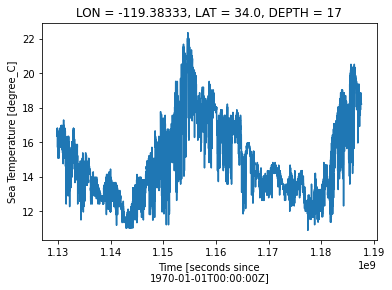

In [16]:
ds_anacapa2["Temperature"].plot()

In [17]:
length1 = ds_anacapa1["Temperature"].size
length2 = ds_anacapa2["Temperature"].size 
length1, length2
print(ds_anacapa1["TIME"].min().values, ds_anacapa1["TIME"].max().values, 
      ds_anacapa2["TIME"].min().values, ds_anacapa1["TIME"].max().values)

1126290600.0 1186522680.0 1129829520.0 1186522680.0


#### create coords and data_vars
- One station is longer than the other
- We have to pad the shorter one to the size of the longer one.
- numpy has a function np.pad for that purpose
- we merge the time variables and the data variables of both stations

In [18]:
time_data = np.concatenate(
    [ds_anacapa1["TIME"].values.squeeze(),
     np.pad(ds_anacapa2["TIME"].values.squeeze(), (0,length1-length2), 'constant', constant_values=-999)]
)
temperature_data = np.concatenate(
    [ds_anacapa1["Temperature"].values.squeeze(),
     np.pad(ds_anacapa2["Temperature"].values.squeeze(), (0,length1-length2), 'constant', constant_values=-999)]
)

#### create the Dataset object
- we create the Dataset object by defining the dimensions station and obs
- we assign the created time and temperature values
- and get the single lat, lon and depth values from the stations

In [19]:
ds = xr.Dataset(data_vars={'temperature': (['station', 'obs'], np.reshape(temperature_data, (2, length1)),)},
                coords={'lon': ('station', [ds_anacapa1["LON"].values[0],ds_anacapa2["LON"].values[0]],),
                        'lat': ('station', [ds_anacapa1["LAT"].values[0],ds_anacapa2["LAT"].values[0]],),
                        'depth': ('station', [ds_anacapa1["DEPTH"].values[0],ds_anacapa2["DEPTH"].values[0]],),
                        'time': (['station', 'obs'], np.reshape(time_data, (2, length1)),),
                        'stationname': ('station', ["Anacapa_East_Fish_Camp", "Anacapa_Black_Sea_Bass_Reef"], ),})

In [20]:
ds

<xarray.Dataset>
Dimensions:      (station: 2, obs: 16733)
Coordinates:
    lon          (station) float32 -119.4 -119.4
    lat          (station) float32 34.0 34.0
    depth        (station) int32 11 17
    time         (station, obs) float64 1.126e+09 1.126e+09 ... -999.0 -999.0
    stationname  (station) <U27 'Anacapa_East_Fish_Camp' 'Anacapa_Black_Sea_B...
Dimensions without coordinates: station, obs
Data variables:
    temperature  (station, obs) float32 17.68 17.52 17.52 ... -999.0 -999.0

In [21]:
ds.info()

xarray.Dataset {
dimensions:
	station = 2 ;
	obs = 16733 ;

variables:
	float32 temperature(station, obs) ;
	float32 lon(station) ;
	float32 lat(station) ;
	int32 depth(station) ;
	float64 time(station, obs) ;
	<U27 stationname(station) ;

// global attributes:
}

#### adding attributes
we add attributes that we can copy from the original datasets

In [22]:
ds['temperature'].attrs = {'units': 'K', 'standard_name': 'air_temperature', "_FillValue": -999.0}
ds['lon'].attrs = {'units': 'degrees_east', 'standard_name': 'longitude', 'axis':'X'}
ds['lat'].attrs = {'units': 'degrees_north', 'standard_name': 'latitude', 'axis':'Y'}
ds['depth'].attrs = {'units': 'm', 'standard_name': 'depth', 'axis':'Z', 'positive':'down'}
ds['time'].attrs = {'units':'seconds since 1970-01-01 00:00:00', '_FillValue': -999.0, 'calendar':'standard'}
ds.attrs = {'title':'Sea Temperature (Kelp Forest Monitoring, Channel Islands)',
            'description': 'The subtidal temperature data taken at Channel Islands National Parks Kelp Forest Monitoring Programs permanent monitoring sites. Since 1993, remote temperature loggers manufactured by Onset Computer Corporation were deployed at each site approximately 10-20 cm from the bottom in a underwater housing. Since 1993, three models of temperature loggers (HoboTemp (tm), StowAway (R) and Tidbit(R)) were used to collect temperature data every 1-5 hours depending on the model used.', 
            'contact': 'Roy.Mendelssohn@noaa.gov', 
            'institution': 'Channel Islands National Park, National Park Service',
            'feature_type': 'timeSeries'}

In [23]:
ds

<xarray.Dataset>
Dimensions:      (station: 2, obs: 16733)
Coordinates:
    lon          (station) float32 -119.4 -119.4
    lat          (station) float32 34.0 34.0
    depth        (station) int32 11 17
    time         (station, obs) float64 1.126e+09 1.126e+09 ... -999.0 -999.0
    stationname  (station) <U27 'Anacapa_East_Fish_Camp' 'Anacapa_Black_Sea_B...
Dimensions without coordinates: station, obs
Data variables:
    temperature  (station, obs) float32 17.68 17.52 17.52 ... -999.0 -999.0
Attributes:
    title:         Sea Temperature (Kelp Forest Monitoring, Channel Islands)
    description:   The subtidal temperature data taken at Channel Islands Nat...
    contact:       Roy.Mendelssohn@noaa.gov
    institution:   Channel Islands National Park, National Park Service
    feature_type:  timeSeries

In [24]:
ds.info()

xarray.Dataset {
dimensions:
	station = 2 ;
	obs = 16733 ;

variables:
	float32 temperature(station, obs) ;
		temperature:units = K ;
		temperature:standard_name = air_temperature ;
		temperature:_FillValue = -999.0 ;
	float32 lon(station) ;
		lon:units = degrees_east ;
		lon:standard_name = longitude ;
		lon:axis = X ;
	float32 lat(station) ;
		lat:units = degrees_north ;
		lat:standard_name = latitude ;
		lat:axis = Y ;
	int32 depth(station) ;
		depth:units = m ;
		depth:standard_name = depth ;
		depth:axis = Z ;
		depth:positive = down ;
	float64 time(station, obs) ;
		time:units = seconds since 1970-01-01 00:00:00 ;
		time:_FillValue = -999.0 ;
		time:calendar = standard ;
	<U27 stationname(station) ;

// global attributes:
	:title = Sea Temperature (Kelp Forest Monitoring, Channel Islands) ;
	:description = The subtidal temperature data taken at Channel Islands National Parks Kelp Forest Monitoring Programs permanent monitoring sites. Since 1993, remote temperature loggers manufac

#### write netCDF file
- I let xarray create a relative time variable with proper attributes

In [27]:
ds.to_netcdf("NOAA_Anacapa_Merged_Sea_Temperature.nc")

In [28]:
!ncdump -h NOAA_Anacapa_Merged_Sea_Temperature.nc

netcdf NOAA_Anacapa_Merged_Sea_Temperature {
dimensions:
	station = 2 ;
	obs = 16733 ;
variables:
	float temperature(station, obs) ;
		temperature:_FillValue = -999.f ;
		temperature:units = "K" ;
		temperature:standard_name = "air_temperature" ;
		temperature:coordinates = "depth lon time lat stationname" ;
	float lon(station) ;
		lon:_FillValue = NaNf ;
		lon:units = "degrees_east" ;
		lon:standard_name = "longitude" ;
		lon:axis = "X" ;
	float lat(station) ;
		lat:_FillValue = NaNf ;
		lat:units = "degrees_north" ;
		lat:standard_name = "latitude" ;
		lat:axis = "Y" ;
	int depth(station) ;
		depth:units = "m" ;
		depth:standard_name = "depth" ;
		depth:axis = "Z" ;
		depth:positive = "down" ;
	double time(station, obs) ;
		time:_FillValue = -999. ;
		time:units = "seconds since 1970-01-01 00:00:00" ;
		time:calendar = "standard" ;
	string stationname(station) ;

// global attributes:
		:title = "Sea Temperature (Kelp Forest Monitoring, Channel Islands)" ;
		:description = "The subti

Text(0, 0.5, 'K')

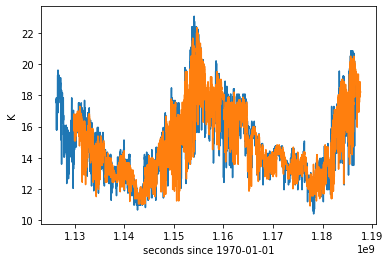

In [29]:
ds_merged = xr.open_dataset("NOAA_Anacapa_Merged_Sea_Temperature.nc", decode_times=False)
plt.plot(ds_merged["time"][0,:],ds_merged["temperature"][0,:])
plt.plot(ds_merged["time"][1,:],ds_merged["temperature"][1,:])
plt.xlabel("seconds since 1970-01-01")
plt.ylabel("K")